In [248]:
import numpy as np

POLYNOMIAL_KERNEL = "polynomial"

class SVM:
    def __init__(self, C = 1.0, kernel = "none") -> None:
        self.C = C # regularization parameter
        self.kernel = kernel # kernel function

    def computeDotProduct(self, w: np.array, b: float, x: np.array, y: float) -> float:
        return 1 - y * self.computePrediction(w,b,x)

    def computePrediction(self, w: np.array, b: float, x: np.array) -> float:
        return np.dot(w,x.T) + b
    
    def polynomialKernel(self, x: np.array, degree: int = 2) -> np.array:
        x = np.c_[ x, np.zeros(x.shape[0]) ] 
        for i in range(x.shape[0]): # basically implement  kernel function
            x[i][2] = x[i][0] * x[i][1]
            # x[i][3] = x[i][0] ** 2
            x[i][0] = x[i][0] ** 2
            x[i][1] = x[i][1] ** 2
            # x[i][4] = x[i][1] ** 2

        return x

    def hingeloss(self, w: np.array, b: float, x: np.ndarray, y: np.array) -> float:
        # check if the dimensions are correct
        regularizer: float = 0.5 * np.linalg.norm(w) ** 2
        loss: float = regularizer
        for i in range(x.shape[0]):
            optimizationTerm: float = self.computeDotProduct(w,b,x[i],y[i]) # since the w and x are vectors, horizontal ones, we need to transpose x
            loss += self.C * max(0,optimizationTerm)
        return loss
    
    def fit(self, X: np.ndarray, Y: np.ndarray, batchSize: int = 100, learningRate: float = 0.001, epochs: int = 1000) -> (np.array,float,  list):
        if self.kernel == POLYNOMIAL_KERNEL:
            X = self.polynomialKernel(X)
        
        numberOfFeatures: int = X.shape[1]
        numberOfSamples: int = X.shape[0]
        ids = np.arange(numberOfSamples) # ids of the samples
        np.random.shuffle(ids) # shuffle the ids
        w: np.array = np.zeros((1,numberOfFeatures))[0]
        b: float = 0
        losses: list = []

        for _ in range(epochs):
            loss = self.hingeloss(w,b,X,Y)
            losses.append(loss)

            for batchInitial in range(0,numberOfSamples,batchSize):
                gradW: float = 0
                gradB: float = 0
                for j in range (batchInitial, batchInitial + batchSize):
                    if j < numberOfSamples:
                        optimizationTerm: float = self.computeDotProduct(w,b,X[ids[j]],Y[ids[j]])
                        if optimizationTerm > 0:
                            gradW += self.C * Y[ids[j]] * X[ids[j]]
                            gradB += self.C * Y[ids[j]]
                w = w - learningRate * w + learningRate * gradW
                b = b + learningRate * gradB
        return w,b,losses

    def fitN(self, X: np.ndarray, Y: np.ndarray, batchSize: int = 100, learningRate: float = 0.001, epochs: int = 1000) -> (np.array,float):
        classes = len(np.unique(Y))

        w = np.zeros((classes,X.shape[1]))
        b = np.zeros(classes)

        for i in range(classes):
            yTemp = np.copy(y)
            yTemp[yTemp != i] = -1
            yTemp[yTemp == i] = 1
            w[i], b[i], _ = self.fit(X,yTemp,batchSize=batchSize,learningRate=learningRate,epochs=epochs)

        return w,b

    def predict(self, X: np.ndarray, w: np.ndarray, b: float) -> np.array:
        if self.kernel == POLYNOMIAL_KERNEL:
            X = self.polynomialKernel(X)
        if w.ndim > 1:
            prediction = np.matmul(X,w.T) +b 
            return np.argmax(prediction,axis=1)
        else:
            prediction = self.computePrediction(w,b,X)
            return np.sign(prediction)
        
    def accuracy(self, X: np.ndarray, Y: np.ndarray, w: np.ndarray, b: float) -> float:
        predictions = self.predict(X,w,b)
        return np.mean(predictions == Y)

$$\min {\frac {1}{2} \|w\|^2} + C_i \cdot \sum_{i=1}^n \max{\{0,1-y_n(w^Tx+b)\}}$$

In [249]:
svm = SVM()
# print(SVM.hingeloss(np.array([1,2]),1,np.array([[1,2],[3,4],[5,6]]),np.array([1,-1,1])))
w, b, losses = svm.fit(np.array([[1,2],[3,4],[5,6]]),np.array([1,-1,1]))
print(w,b,losses)
print(svm.predict(np.array([[1,2],[3,4],[5,6]]),w,b))

[-0.07281361  0.16554549] 0.3840000000000003 [3.0, 2.9740124999999997, 2.9480749500125, 2.922187250187425, 2.8963493008743004, 2.8705610026218524, 2.8448222561776118, 2.8191329624875126, 2.7934930226955004, 2.7679023381431316, 2.742360810369183, 2.7168683411092553, 2.691424832295378, 2.66603018605562, 2.6406843047136945, 2.6153870907885715, 2.590138446994086, 2.5649382762385446, 2.5397864816243434, 2.5146829664475767, 2.4896276341976478, 2.4646203885568863, 2.439661133400161, 2.414749772794494, 2.3898862109986783, 2.365070352462892, 2.3677279213347853, 2.3589968332200373, 2.3688372292571565, 2.3645499729598516, 2.3583282047632492, 2.3700959694497827, 2.3613601476068524, 2.3621092974489306, 2.3669109276949634, 2.358181472750501, 2.3658776486023445, 2.3637370157475326, 2.3553693151158743, 2.369285407601799, 2.360551206072003, 2.3591518606807713, 2.3661043680380343, 2.357376525406326, 2.362921650926208, 2.3629344368730316, 2.3542129309337225, 2.3666787146356807, 2.35977557138958, 2.356159

In [250]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Creating dataset
X, y = datasets.make_blobs(
        n_samples = 100, # Number of samples
        n_features = 2, # Features
        centers = 2,
        cluster_std = 1,
        random_state=41
    )

# Classes 1 and -1
y = np.where(y == 0, -1, 1)

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

svm = SVM()

w, b, losses = svm.fit(X_train, y_train)

# Loss value
lss = losses.pop()

print("Loss:", lss)
print("Prediction:", svm.predict(X_test,w,b))
print("Accuracy:", svm.accuracy(X_test, y_test, w, b))
print("w:", w)
print("b:", b)

Loss: 0.07822422348429103
Prediction: [ 1. -1.  1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1. -1.
 -1.  1.  1. -1. -1.  1. -1. -1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1.
 -1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1. -1. -1. -1.]
Accuracy: 1.0
w: [ 0.39469747 -0.01869803]
b: 0.025000000000000015


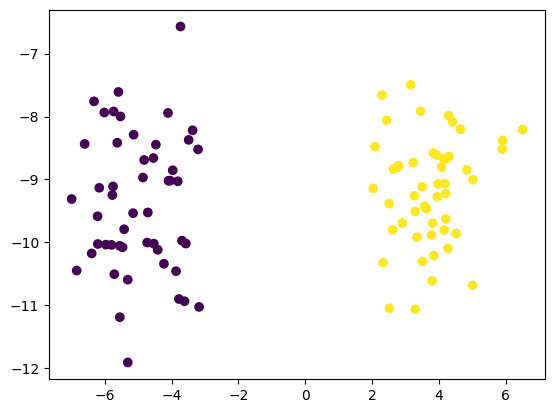

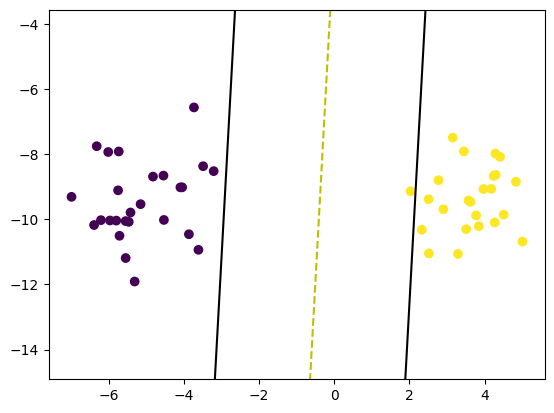

In [252]:
# Visualizing the scatter plot of the dataset
def visualize_dataset(X: np.ndarray = X, y: np.ndarray = y):
    plt.scatter(X[:, 0], X[:, 1], c=y)


# Visualizing SVM
def visualize_svm(w: np.array,b: float, X: np.ndarray, XTest: np.ndarray, yTest: np.ndarray):
    # split w to w and b where b is first element of w
    # b = w[0]
    # w = w[1:] 

    def get_hyperplane_value(x, w, b, offset):
        return (-w[0] * x + b + offset) / w[1]

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.scatter(XTest[:, 0], XTest[:, 1], marker="o", c=yTest)

    x0_1 = np.amin(XTest[:, 0])
    x0_2 = np.amax(XTest[:, 0])

    x1_1 = get_hyperplane_value(x0_1, w, b, 0)
    x1_2 = get_hyperplane_value(x0_2, w, b, 0)

    x1_1_m = get_hyperplane_value(x0_1, w, b, -1)
    x1_2_m = get_hyperplane_value(x0_2, w, b, -1)

    x1_1_p = get_hyperplane_value(x0_1, w, b, 1)
    x1_2_p = get_hyperplane_value(x0_2, w, b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])

    plt.show()


visualize_dataset(X, y)
visualize_svm(w, b, X, X_test, y_test)

Kernels

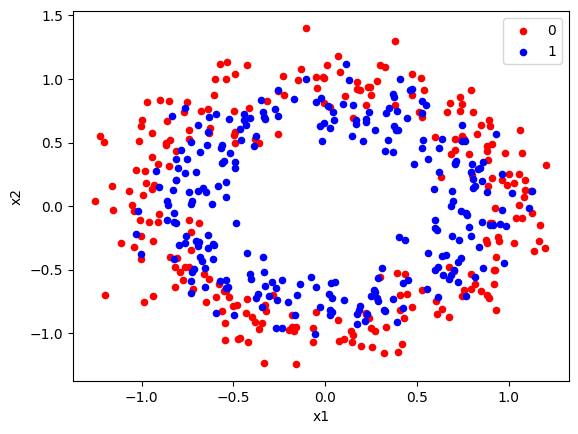

In [253]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=500, noise=0.13, random_state=42)

df = pd.DataFrame(dict(x1=X[:, 0], x2=X[:, 1], y=y))

colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('y')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x1', y='x2', label=key, color = colors[key])
plt.show()

In [254]:
y[y == 0] = -1 # change to -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

svm = SVM()

w, b, losses = svm.fit(X_train, y_train)

# Loss value
lss = losses.pop()

print("Loss:", lss)
print("Prediction:", svm.predict(X_test,w,b))
print("Accuracy:", svm.accuracy(X_test, y_test, w, b))
print("w:", w)
print("b:", b)

Loss: 238.13336350144334
Prediction: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

svm = SVM(kernel=POLYNOMIAL_KERNEL)

w, b, losses = svm.fit(X_train, y_train)
# Loss value
lss = losses.pop()

print("Loss:", lss)
print("Prediction:", svm.predict(X_test,w,b))
print("Accuracy:", svm.accuracy(X_test, y_test, w, b))
print("w:", w)
print("b:", b)

Loss: 157.1697103580051
Prediction: [-1. -1. -1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.
  1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1.
 -1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  1. -1.  1.  1.  1.  1. -1. -1.
  1. -1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1. -1.  1.  1. -1. -1.
 -1.  1. -1. -1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.
 -1.  1. -1. -1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1.  1.
  1. -1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.  1. -1. -1. -1.  1.  1.
  1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1.  1.
 -1.  1.  1. -1. -1.  1.  1. -1. -1.  1. -1. -1.  1.  1. -1.  1. -1.  1.
  1.  1. -1.  1.  1. -1. -1.  1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1.
  1. -1. -1.  1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1. -1.
  1.  1. -1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1. -1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.
 -1.  1. -1. -1

In [256]:
import plotly.express as px

df['x1^2'] = df['x1'] ** 2
df['x2^2'] = df['x2'] ** 2
df['x1 * x2'] = df['x1'] * df['x2']
df['x1^2 + x2^2'] = df['x1'] ** 2 + df['x2'] **2

fig = px.scatter_3d(df, x='x1', y='x2', z='x1 * x2', color='y')
fig.show()

In [257]:
fig = px.scatter_3d(df, x='x1^2', y='x2^2', z='x1 * x2', color='y')
fig.show()

In [258]:
fig = px.scatter_3d(df, x='x1', y='x2', z='x1^2 + x2^2', color='y')
fig.show()

In [259]:
# lets imagine we want to classify n classes from a data set
# we can use one vs rest method
# basically we will train n different classifiers, one for each class

from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

svm = SVM()
w,b = svm.fitN(X,y)

print(w)
print(b)
print(svm.predict(X,w,b))
print(y)
print(svm.accuracy(X,y,w,b))


[[ 0.16318374  0.47350427 -0.87009308 -0.48870072]
 [ 0.46104043 -1.57930269  0.34501858 -1.25107564]
 [-0.93639374 -1.10002321  1.69702016  1.85008771]]
[ 0.357  1.542 -2.436]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1
 1 1 1 2 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
0.9533333333333334
